2025-05-27 10:42:41.731926: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 10:42:41.748595: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 10:42:41.950432: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 10:42:42.109467: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748342562.404047   14628 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748342562.50

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.1807 - loss: 2.9978 - val_accuracy: 0.3949 - val_loss: 1.9276
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.6269 - loss: 1.2548 - val_accuracy: 0.7357 - val_loss: 0.8676
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.8399 - loss: 0.5365 - val_accuracy: 0.8025 - val_loss: 0.6531
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.8935 - loss: 0.3385 - val_accuracy: 0.8471 - val_loss: 0.4897
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9378 - loss: 0.2186 - val_accuracy: 0.8726 - val_loss: 0.5221
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.9737 - loss: 0.1134 - val_accuracy: 0.8822 - val_loss: 0.4403
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9885 - loss: 0.0475 - val_accuracy: 0.9172 - val_loss: 0.3244
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9970 - loss: 0.0260 - val_accu

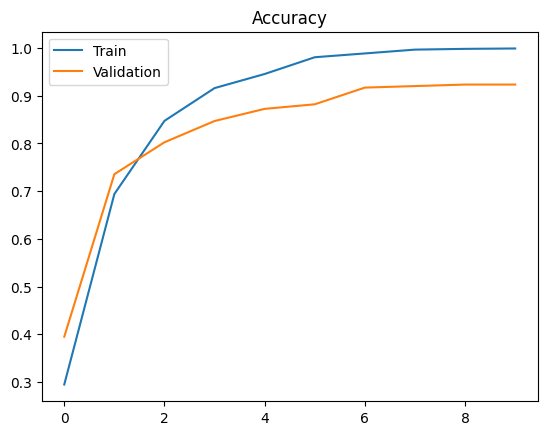

In [1]:
# Bildverarbeitung & Klassifikation (PIL statt OpenCV)
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

# CSV einlesen
df = pd.read_csv("metadata.csv")

# Nur Bilder verwenden, die tatsächlich vorhanden sind
df = df[df["image_name"].apply(lambda x: os.path.exists(os.path.join("images", x)))]

# Top-Marken (mind. 50 Bilder)
top_brands = df["brand"].value_counts()[df["brand"].value_counts() >= 50].index
df = df[df["brand"].isin(top_brands)].reset_index(drop=True)

# Labels kodieren
le = LabelEncoder()
df["label"] = le.fit_transform(df["brand"])

# Bilder laden mit PIL
images = []
labels = []

for _, row in df.iterrows():
    img_path = os.path.join("images", row["image_name"])
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((128, 128))
        img_array = np.array(img) / 255.0
        images.append(img_array)
        labels.append(row["label"])
    except:
        continue  # falls ein Bild beschädigt ist

X = np.array(images)
y = to_categorical(labels)

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN-Modell bauen
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

# Kompilieren & Trainieren
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Bewertung & Plot
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Genauigkeits-Plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.show()


In [17]:
import pandas as pd
import os

# Load metadata
df = pd.read_csv("metadata.csv")

# Filter out rows where the image file does not exist
df = df[df["image_name"].apply(lambda x: os.path.exists(os.path.join("images", x)))]

# Count how many images each brand has
brand_counts = df["brand"].value_counts()

# Keep only brands with at least 2 images
valid_brands = brand_counts[brand_counts >= 2].index
df = df[df["brand"].isin(valid_brands)].reset_index(drop=True)


In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["brand_encoded"] = le.fit_transform(df["brand"])


In [19]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["brand_encoded"],
    random_state=42
)


In [20]:
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)


In [25]:
# ✅ Recalculate number of classes from the final CSV
num_classes = train_df["brand_encoded"].nunique()
print(f"✅ Number of classes: {num_classes}")


✅ Number of classes: 64


In [26]:
from tensorflow.keras.utils import Sequence, to_categorical
import cv2
import numpy as np

class ImageDataGenerator(Sequence):
    def __init__(self, df, image_folder, batch_size=32, img_size=(128, 128)):
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.labels = df['brand_encoded'].values
        self.image_names = df['image_name'].values

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.image_names[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        images = []
        for img_name in batch_images:
            img_path = os.path.join(self.image_folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, self.img_size) / 255.0
                images.append(img)
        
        images = np.array(images)
        labels = to_categorical(batch_labels[:len(images)])
        return images, labels


In [27]:
train_gen = ImageDataGenerator(train_df, image_folder="images")
val_gen = ImageDataGenerator(val_df, image_folder="images")


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# ✅ Use recalculated num_classes
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/codespace/.local/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/codespace/.local/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/local/python/3.12.1/lib/python3.12/asyncio/base_events.py", line 638, in run_forever

  File "/usr/local/python/3.12.1/lib/python3.12/asyncio/base_events.py", line 1971, in _run_once

  File "/usr/local/python/3.12.1/lib/python3.12/asyncio/events.py", line 84, in _run

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/codespace/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3047, in run_cell

  File "/home/codespace/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3102, in _run_cell

  File "/home/codespace/.local/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/codespace/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/home/codespace/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3489, in run_ast_nodes

  File "/home/codespace/.local/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code

  File "/tmp/ipykernel_14628/997587519.py", line 1, in <module>

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 61, in train_step

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/losses/losses.py", line 33, in call

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/losses/losses.py", line 2181, in categorical_crossentropy

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/ops/nn.py", line 1915, in categorical_crossentropy

  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py", line 679, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,64] labels_size=[32,58]
	 [[{{node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_multi_step_on_iterator_18520]

: 